In [1]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation
import matplotlib.pyplot as plt
import ale_py
from stable_baselines3.common.atari_wrappers import AtariWrapper
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

Observation shape: (4, 84, 84)
Action space: Discrete(7)


A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


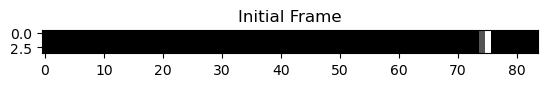

In [2]:
# Calling the environment
env = gym.make("ALE/Assault-v5", render_mode="rgb_array", frameskip=1)

# Using AtariPreprocessing
env = AtariPreprocessing(
    env,
    frame_skip=4,          
    grayscale_obs=True,     
    scale_obs=False,      
    terminal_on_life_loss=False
)

# Stack 4 frames to capture motion
env = FrameStackObservation(env, stack_size=4)

# Testing the environment
obs, info = env.reset()
print("Observation shape:", obs.shape)
print("Action space:", env.action_space)

# Visualizing the first frame
plt.imshow(obs[:, :, 0], cmap="gray")
plt.title("Initial Frame")
plt.show()

# Close the environment
env.close()

### Environment Visualization

In [4]:
# Creating the environment

env = gym.make("ALE/Assault-v5", render_mode="rgb_array")

# Atari Wrapper for handling the environment

env=AtariWrapper(env, frame_skip=4, terminal_on_life_loss=False, clip_reward=True)

# Stacking Images for motion visualization
# env = FrameStackObservation(env, stack_size=4)

In [5]:
# Checking how the output looks like

obs, info = env.reset()
print("Observation Shape:", obs.shape)
print("Action Space:", env.action_space)

Observation Shape: (84, 84, 1)
Action Space: Discrete(7)


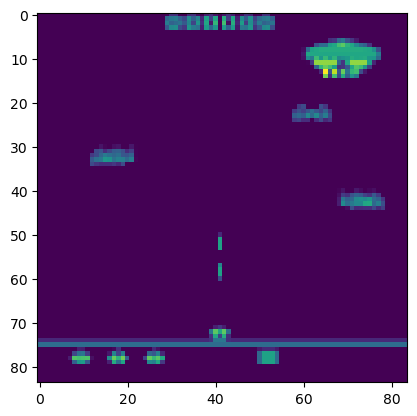

In [6]:
# Visualizing frame

plt.imshow(obs[:,:,0])
plt.show()

Step: Reward=0.0, Terminated=False, Truncated=False


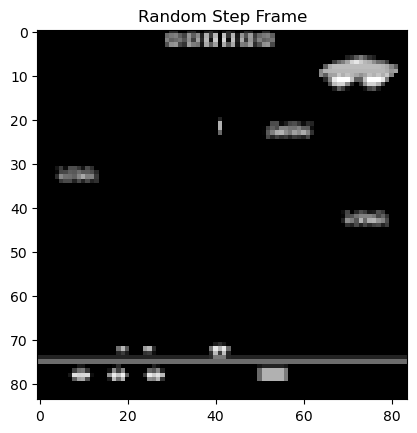

Step: Reward=0.0, Terminated=False, Truncated=False


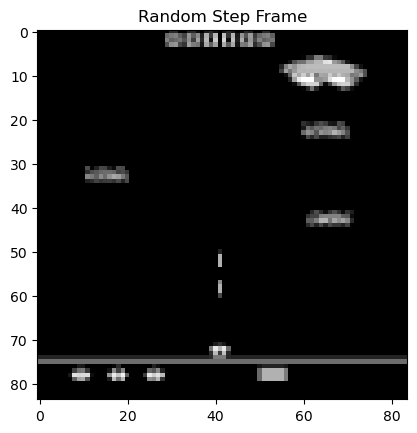

Step: Reward=0.0, Terminated=False, Truncated=False


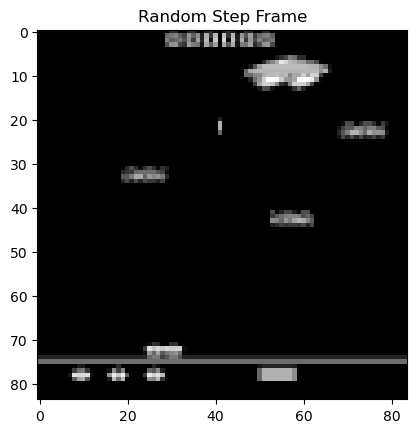

Step: Reward=0.0, Terminated=False, Truncated=False


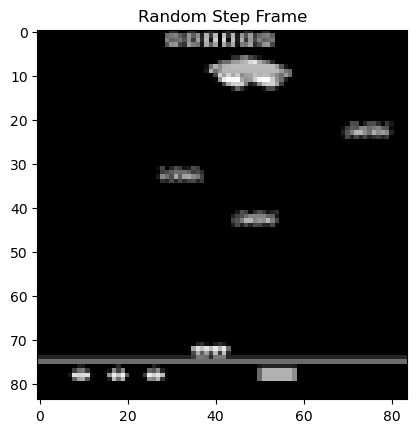

Step: Reward=0.0, Terminated=False, Truncated=False


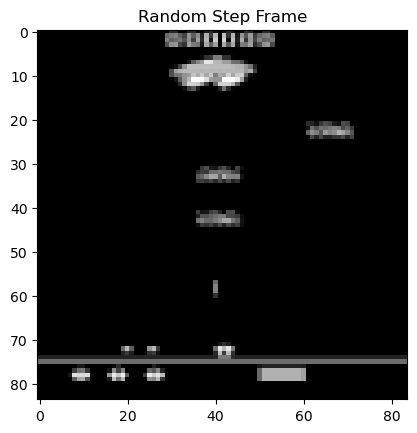

In [7]:
# Taking five random actions and visualizing the environment

for i in range(5):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Step: Reward={reward}, Terminated={terminated}, Truncated={truncated}")
    plt.imshow(obs[:, :, 0], cmap="gray")
    plt.title("Random Step Frame")
    plt.show()
    if terminated or truncated:
        obs, info = env.reset()

### DQN Implementation

In [9]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    BATCH_SIZE = 32
    EPSILON_START = 1
    EPSILON_CUTOFF = 0.05
    EPSILON_DECAY = 10000 # x 10
    GAMMA = 0.99
    LR = 1e-4
    MEMORY_SIZE = 10000
    total_steps = 0

    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN().to(self.device)
        self.target_net = DQN().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.LR)
        self.memory = ReplayBuffer(self.MEMORY_SIZE)
        self.steps_done = 0
        self.epsilon = self.EPSILON_START

    def select_e_greedy_action(self, env, state):
        if random.random() < self.epsilon:
            return random.randint(0, env.action_space.n - 1)
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                return self.policy_net(state).argmax(dim=1).item()

    def select_greedy_action(self, state):
      state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
      with torch.no_grad():
          return self.policy_net(state).argmax(dim=1).item()

    def decay_epsilon(self):
      self.total_steps += 1
      self.epsilon = max(self.EPSILON_CUTOFF, self.EPSILON_START - (self.total_steps / self.EPSILON_DECAY))

    def step(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        batch = self.memory.sample(self.BATCH_SIZE)

        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device).unsqueeze(1)
        current_q = self.policy_net(states).gather(1, actions)
        next_q = self.target_net(next_states).max(1, keepdim=True)[0].detach()
        target_q = rewards + (self.GAMMA * next_q * (1 - dones))

        loss = F.mse_loss(target_q, current_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

### Training Function

In [11]:
def train_q_values(env, env_name,target_update_interval = 10, training_episodes = 1000, agent_class = DQNAgent):
  MAX_STEPS = 200

  agent = agent_class()
  rewards_per_episode = []
  epsilon_values = []

  for episode in range(training_episodes):
    obs, _ = env.reset()
    state = obs
    total_reward = 0
    done = False
    steps_taken = 0
    episode_transitions = []

    epsilon_values.append(agent.epsilon)

    while not done and steps_taken < MAX_STEPS:
        action = agent.select_e_greedy_action(env, state)
        obs, reward, done, _, _ = env.step(action)
        next_state = np.array(obs, dtype=np.float32)
        episode_transitions.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        steps_taken += 1

        agent.decay_epsilon()

    for transition in episode_transitions:
        agent.memory.push(*transition)

    for _ in range(len(episode_transitions)):
        agent.step()

    rewards_per_episode.append(total_reward)

    if episode % target_update_interval == 0:
      agent.update_target_network()

    if episode % 10 == 0:
      print(f"Episode {episode + 1}: Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")
      torch.save(agent.policy_net.state_dict(), "dqn_assult_env_v5.pth")

  plt.plot(rewards_per_episode)
  plt.xlabel("Iteration")
  plt.ylabel("Reward")
  plt.title(f"{env_name} Reward Characteristics - Training")
  plt.show()

  plt.plot(epsilon_values, label=f"Decay rate = {DQNAgent.EPSILON_DECAY}")
  plt.xlabel("Episode")
  plt.ylabel("Epsilon")
  plt.title(f"{env_name} Epsilon Characteristics - Training")
  plt.show()

  return agent

### Evaluation Function

In [50]:
def evaluate_agent(env, agent, env_name, policy, episodes_count = 10):
  MAX_STEPS = 700

  agent.policy_net.load_state_dict(torch.load(policy))
  eval_rewards = []

  for _ in range(episodes_count):
      obs, _ = env.reset()
      state = obs
      done = False
      total_reward = 0
      steps_taken = 0

      while not done and steps_taken < MAX_STEPS:
          action = agent.select_greedy_action(state)
          state, reward, done, _, _ = env.step(action)
          total_reward += reward
          steps_taken += 1
      eval_rewards.append(total_reward)

  plt.plot(eval_rewards, marker="o")
  plt.xlabel("Episode")
  plt.ylabel("Reward")
  plt.title(f"{env_name} Reward Characteristics - Evaluation")

  plt.show()

  print(f"{env_name} average reward over 10 episodes: {np.mean(eval_rewards)}")

### Assault-v5 DQN Agent - Training

Episode 1: Total Reward: 84.0, Epsilon: 0.980
Episode 11: Total Reward: 147.0, Epsilon: 0.780
Episode 21: Total Reward: 84.0, Epsilon: 0.580
Episode 31: Total Reward: 105.0, Epsilon: 0.380
Episode 41: Total Reward: 63.0, Epsilon: 0.180
Episode 51: Total Reward: 126.0, Epsilon: 0.050
Episode 61: Total Reward: 63.0, Epsilon: 0.050
Episode 71: Total Reward: 168.0, Epsilon: 0.050
Episode 81: Total Reward: 126.0, Epsilon: 0.050
Episode 91: Total Reward: 105.0, Epsilon: 0.050
Episode 101: Total Reward: 105.0, Epsilon: 0.050
Episode 111: Total Reward: 84.0, Epsilon: 0.050
Episode 121: Total Reward: 105.0, Epsilon: 0.050
Episode 131: Total Reward: 63.0, Epsilon: 0.050
Episode 141: Total Reward: 147.0, Epsilon: 0.050
Episode 151: Total Reward: 147.0, Epsilon: 0.050
Episode 161: Total Reward: 147.0, Epsilon: 0.050
Episode 171: Total Reward: 126.0, Epsilon: 0.050
Episode 181: Total Reward: 147.0, Epsilon: 0.050
Episode 191: Total Reward: 84.0, Epsilon: 0.050
Episode 201: Total Reward: 168.0, Epsi

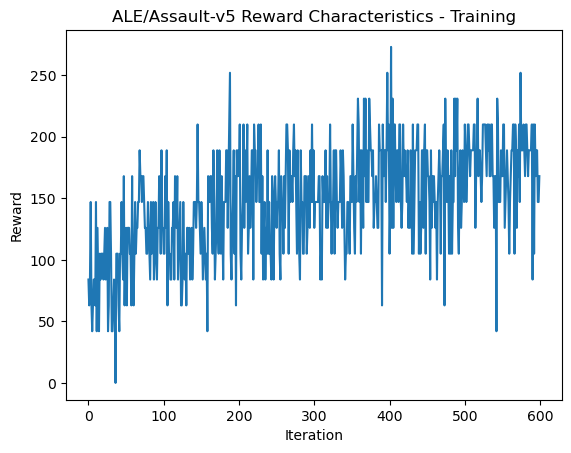

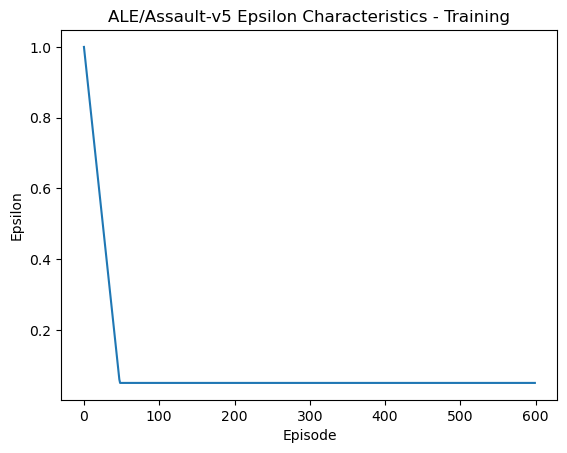

In [15]:
env_name = "ALE/Assault-v5"
assult_env = gym.make(env_name, render_mode="rgb_array", frameskip=1)
assult_env = AtariPreprocessing(
    assult_env,
    frame_skip=4,          
    grayscale_obs=True,     
    scale_obs=False,      
    terminal_on_life_loss=False
)

assult_env = FrameStackObservation(assult_env, stack_size=4)

trained_agent = train_q_values(assult_env, env_name, training_episodes=600)
torch.save(trained_agent.policy_net.state_dict(), "dqn_assult_env_v5.pth")

### Assault-v5 DQN Agent - Evaluation

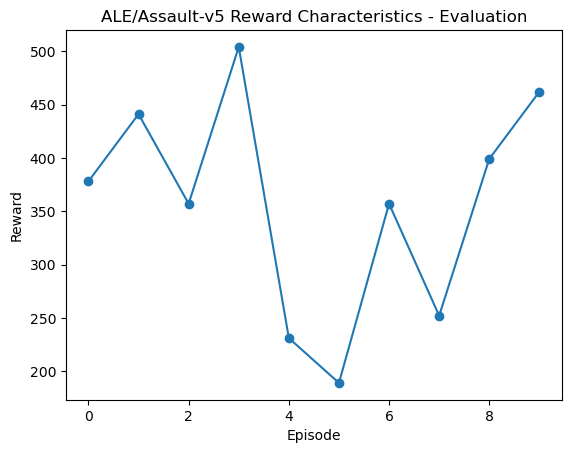

ALE/Assault-v5 average reward over 10 episodes: 357.0


In [17]:
evaluate_agent(assult_env, trained_agent, env_name, "dqn_assult_env_v5.pth")